# Practical Machine Learning for Physicists
## Week 6 Exercise
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

In [175]:
def rhs(t,z,L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [176]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0] # theta 1, w1, theta 2, w2

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [177]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


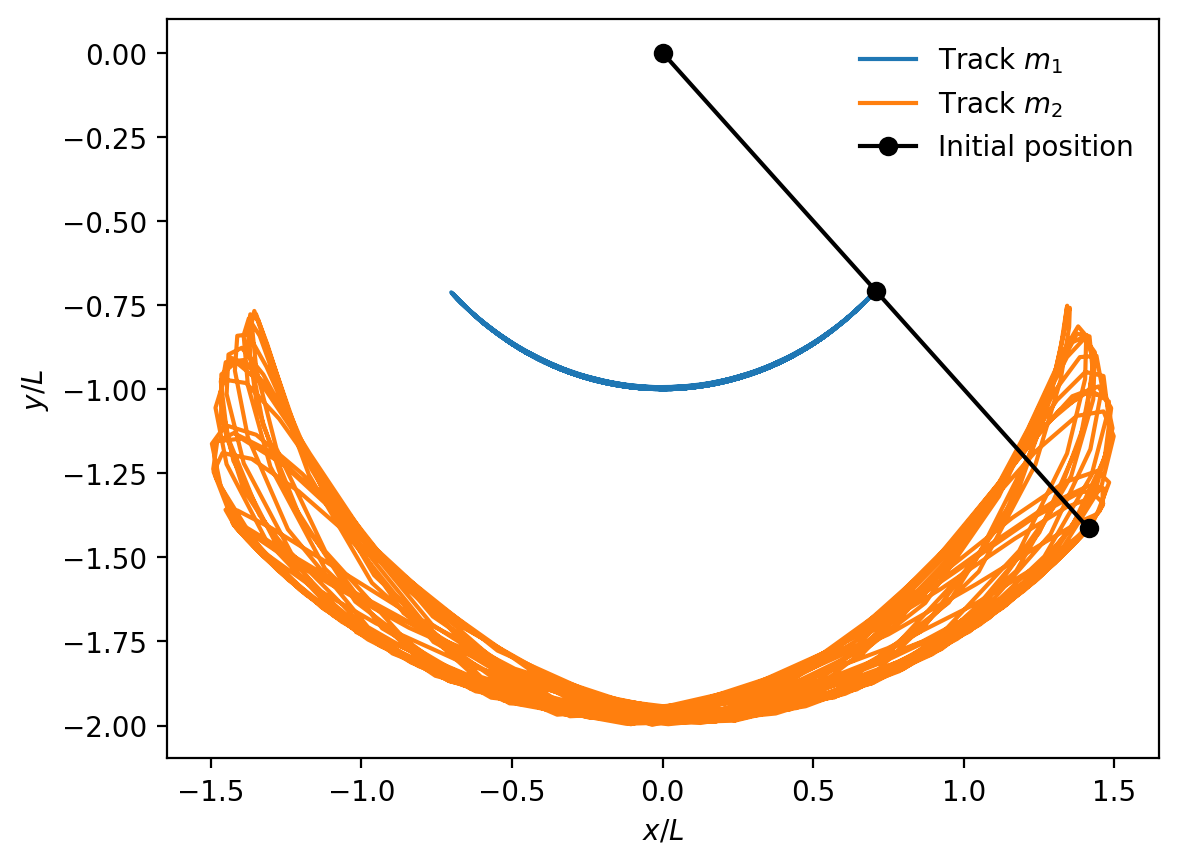

In [178]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

#Part 1

In [179]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Import tqdm for progress bar
from tqdm import tqdm


In [180]:
#Define model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(None,4,),return_sequences=False)) # LSTM layer 20 nodes
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 20)                2000      
                                                                 
 dense_44 (Dense)            (None, 4)                 84        
                                                                 
Total params: 2084 (8.14 KB)
Trainable params: 2084 (8.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
windowsize = 10 #Number of samples we will use to train our network
offset=20 #How far into future we predict

#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows

def shapeArray(x,windowsize,offset):
    xInput = np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel = np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)

#Split data intro training and validation parts

split = int(len(x1)*0.7)

train_data = np.array([x1[0:split], x2[0:split], y1[0:split], y2[0:split]]).T
test_data = np.array([x1[split:-1],x2[split:-1],y1[split:-1],y2[split:-1]]).T

train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

In [182]:
#Train model

# Reshape the input array to have the dimensions (batchsize, time samples, features)

train_data_in = train_dataInput.reshape(train_dataInput.shape[0], train_dataInput.shape[1], 4)
train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 4)

#Get validation data

test_data_in = test_dataInput.reshape(test_dataInput.shape[0], test_dataInput.shape[1], 4)
test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 4)

history = model.fit(train_data_in,train_data_target,batch_size=20,epochs=200,verbose = 0,validation_data=(test_data_in, test_data_target))

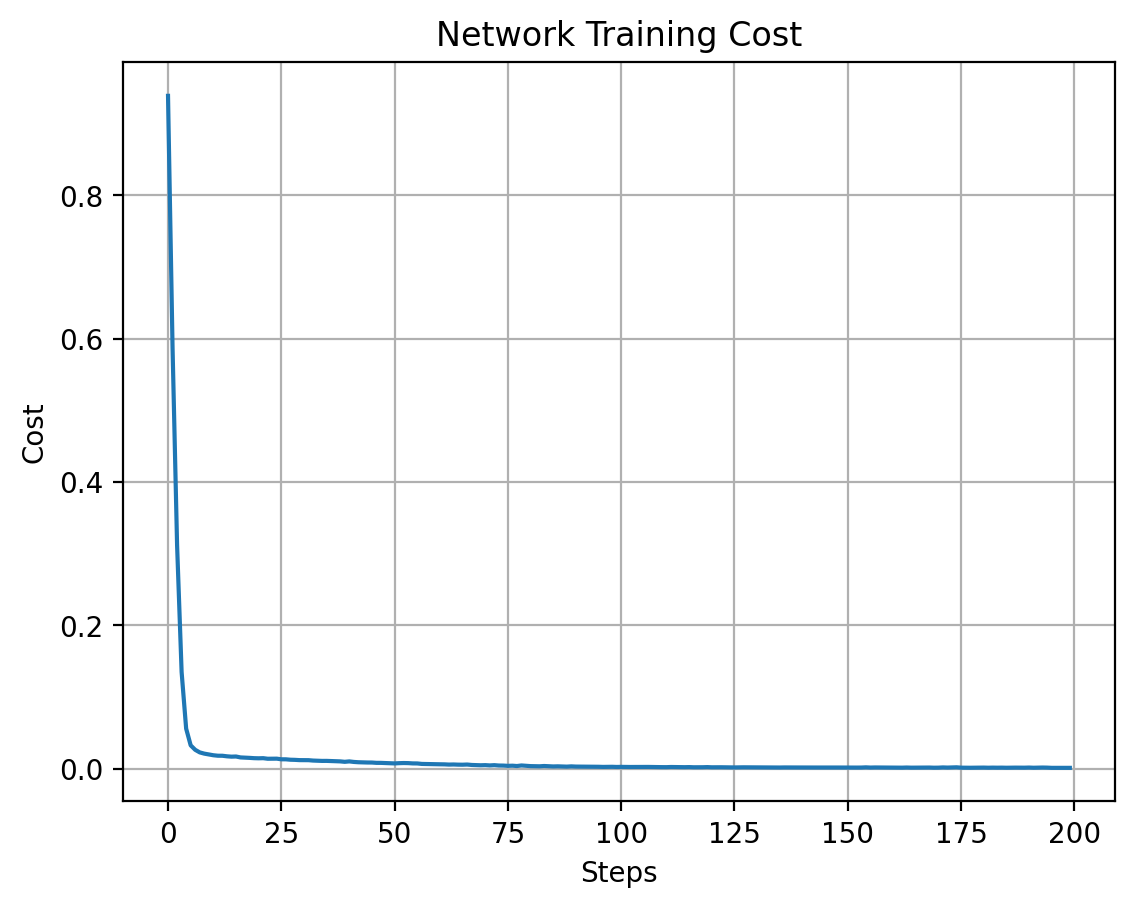

In [183]:
#Plot costs vs steps
steps = 200
fig,ax=plt.subplots()
ax.plot(np.arange(steps),history.history["loss"],label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
plt.grid(True)

#Part 2

4/4 [==============================] - 0s 4ms/step


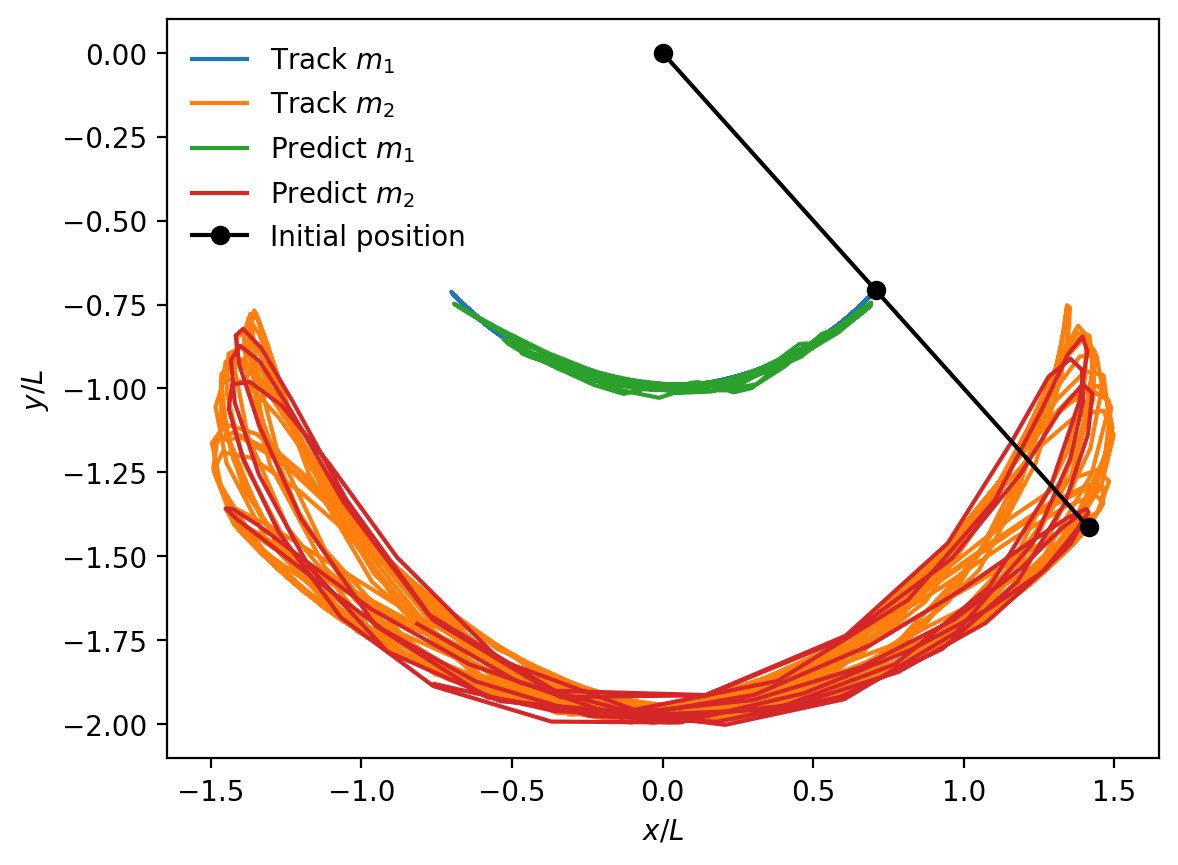

In [184]:
#Plot predictive data over test range
predictions = model.predict(test_data_in)
px1 = predictions[:,0]
px2 = predictions[:,1]
py1 = predictions[:,2]
py2 = predictions[:,3]

# Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")

ax.plot(px1, py1, label=r"Predict $m_1$")
ax.plot(px2, py2, label=r"Predict $m_2$")

ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [160]:
#Varying initail condtions

#Part 3

In [185]:
#Plot individual components and track training cost

offsets = np.arange(20,101,5)
index = 0
test_costs = []

#Setup subplots
fig, axs = plt.subplots(nrows = 5,ncols = 4,figsize = (20,20))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=1)

figs = ((0,0),(0,1),(0,2),(0,3),
      (1,0),(1,1),(1,2),(1,3),
      (2,0),(2,1),(2,2),(2,3),
      (3,0),(3,1),(3,2),(3,3)
      ,(4,0))

for i in offsets:
  windowsize = 10 #Number of samples we will use to train our network
  offset=i #How far into future we predict
  ##### Define params

  train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
  test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

  # Reshape the input array to have the dimensions (batchsize, time samples, features)

  train_data_in = train_dataInput.reshape(train_dataInput.shape[0], train_dataInput.shape[1], 4)
  train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 4)

  #Get validation data

  test_data_in = test_dataInput.reshape(test_dataInput.shape[0], test_dataInput.shape[1], 4)
  test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 4)

  ##### Reset and train model
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(None,4,),return_sequences=False)) # LSTM layer 20 nodes
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')

  history = model.fit(train_data_in,train_data_target,batch_size=20,epochs=200,verbose=0,validation_data=(test_data_in, test_data_target))

  ##### Plot difference betwen predictive data against ivp soultion
  predictions = model.predict(test_data_in)
  px1 = predictions[:,0]
  px2 = predictions[:,1]
  py1 = predictions[:,2]
  py2 = predictions[:,3]

  print(figs[0])
  # Plot the actual vs predicted values
  axs[figs[index]].plot(t[-len(predictions):],x1[-len(predictions):],label=('ivp x1'))
  axs[figs[index]].plot(t[-len(predictions):],px1,label=('prediction x1'))
  axs[figs[index]].plot(t[-len(predictions):],x2[-len(predictions):],label=('ivp x2'))
  axs[figs[index]].plot(t[-len(predictions):],px2,label=('prediction x2'))
  axs[figs[index]].plot(t[-len(predictions):],y1[-len(predictions):],label=('ivp y1'))
  axs[figs[index]].plot(t[-len(predictions):],py1,label=('prediction y1'))
  axs[figs[index]].plot(t[-len(predictions):],y2[-len(predictions):],label=('ivp y2'))
  axs[figs[index]].plot(t[-len(predictions):],py2,label=('prediction y2'))

  axs[figs[index]].set_ylabel(r"$y/L$")
  axs[figs[index]].set_xlabel(r"$x/L$")
  axs[figs[index]].set_title(f"t = t_0 + {i}dt")
  axs[figs[index]].legend(bbox_to_anchor=(1, 1.05))

  index += 1
  test_costs.append(min(history.history["val_loss"]))

Output hidden; open in https://colab.research.google.com to view.

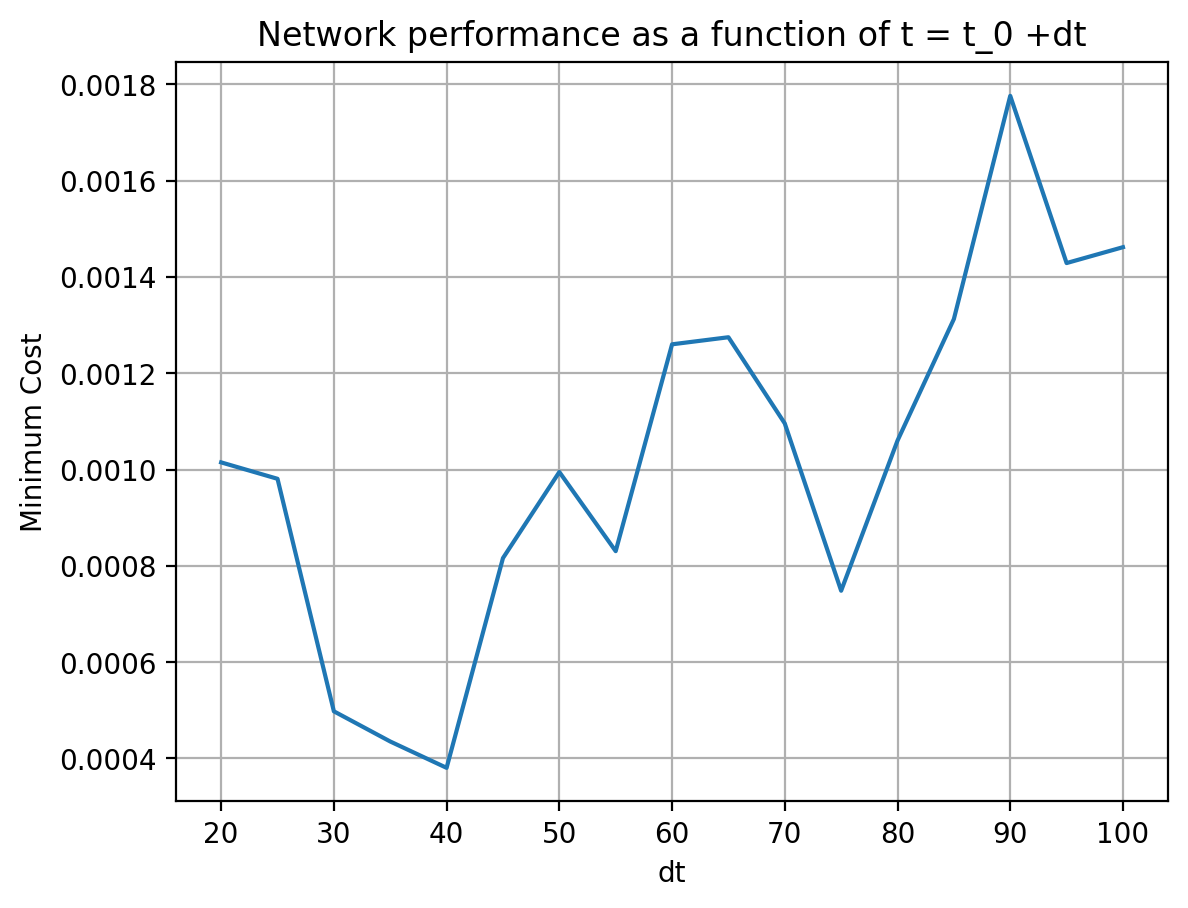

In [186]:
fig,ax=plt.subplots()
ax.plot(offsets,test_costs,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)

#Part 4

In [187]:
#Setup new starting conditions
#Starting angles
z0=[np.pi/2,0,np.pi/2,0] # theta 1, w1, theta 2, w2

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


In [188]:
windowsize = 10 #Number of samples we will use to train our network
offset=20 #How far into future we predict

#Split data intro training and validation parts

split = int(len(x1)*0.7)

train_data = np.array([x1[0:split], x2[0:split], y1[0:split], y2[0:split]]).T
test_data = np.array([x1[split:-1],x2[split:-1],y1[split:-1],y2[split:-1]]).T

train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

In [189]:
#Define model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(None,4,),return_sequences=False)) # LSTM layer 20 nodes
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 20)                2000      
                                                                 
 dense_62 (Dense)            (None, 4)                 84        
                                                                 
Total params: 2084 (8.14 KB)
Trainable params: 2084 (8.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [190]:
#Train model

# Reshape the input array to have the dimensions (batchsize, time samples, features)
train_data_in = train_dataInput.reshape(train_dataInput.shape[0], train_dataInput.shape[1], 4)
train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 4)

#Get validation data
test_data_in = test_dataInput.reshape(test_dataInput.shape[0], test_dataInput.shape[1], 4)
test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 4)

history = model.fit(train_data_in,train_data_target,batch_size=20,epochs=200,verbose = 0,validation_data=(test_data_in, test_data_target))

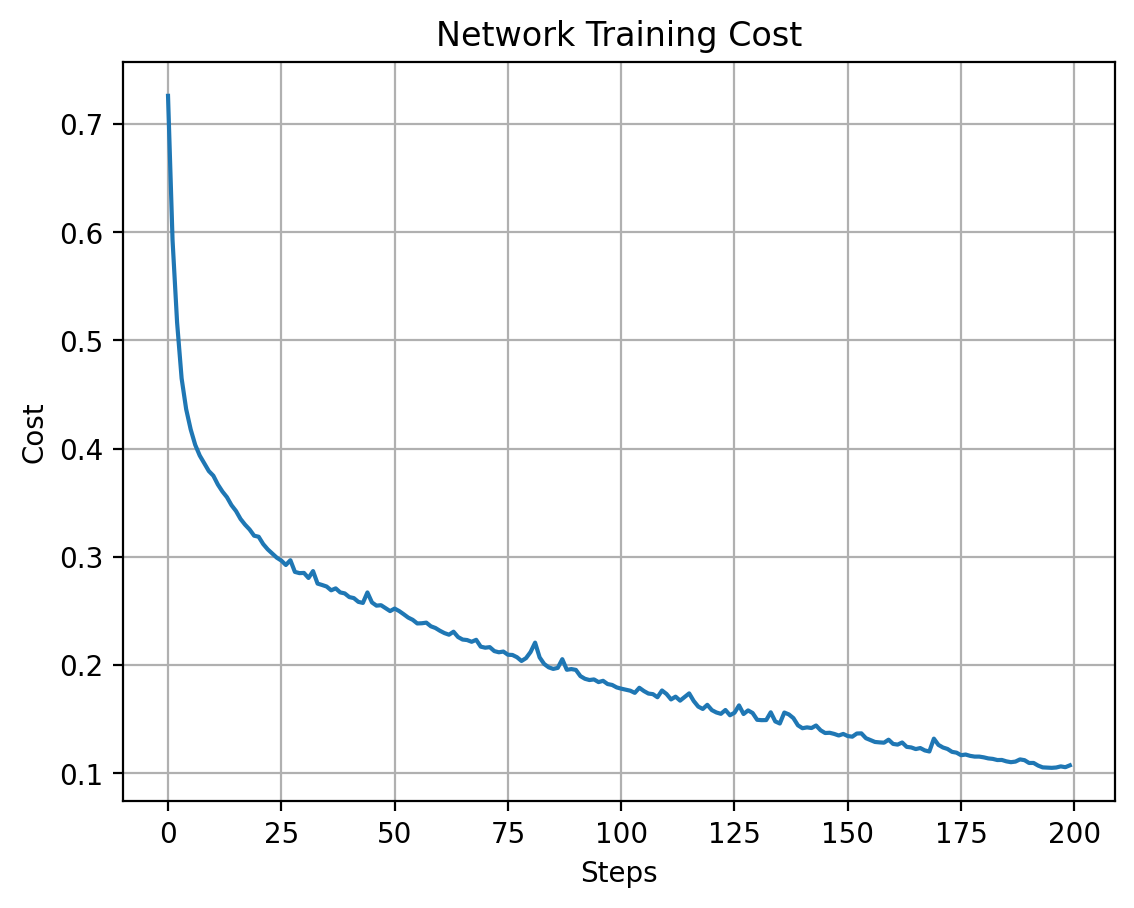

In [191]:
#Plot costs vs steps
steps = 200
fig,ax=plt.subplots()
ax.plot(np.arange(steps),history.history["loss"],label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
plt.grid(True)

4/4 [==============================] - 0s 4ms/step


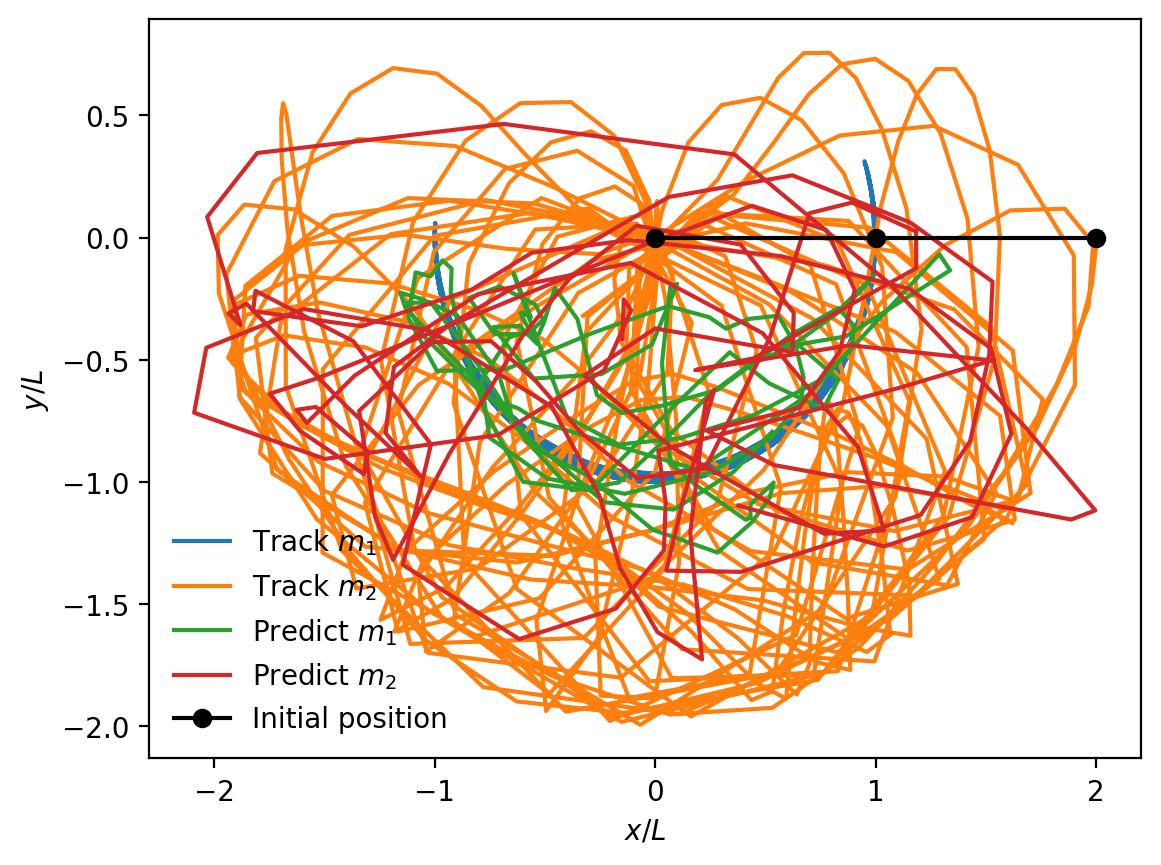

In [192]:
#Plot predictive data over test range
predictions = model.predict(test_data_in)
px1 = predictions[:,0]
px2 = predictions[:,1]
py1 = predictions[:,2]
py2 = predictions[:,3]

# Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")

ax.plot(px1, py1, label=r"Predict $m_1$")
ax.plot(px2, py2, label=r"Predict $m_2$")

ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [ ]:
#Varying initail conditions

In [ ]:
#Plot individual components and track training cost

offsets = np.arange(20,101,5)
index = 0
test_costs = []

#Setup subplots
fig, axs = plt.subplots(nrows = 5,ncols = 4,figsize = (20,20))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=1)

figs = ((0,0),(0,1),(0,2),(0,3),
      (1,0),(1,1),(1,2),(1,3),
      (2,0),(2,1),(2,2),(2,3),
      (3,0),(3,1),(3,2),(3,3)
      ,(4,0))

for i in offsets:
  windowsize = 10 #Number of samples we will use to train our network
  offset=i #How far into future we predict
  ##### Define params

  train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
  test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

  # Reshape the input array to have the dimensions (batchsize, time samples, features)

  train_data_in = train_dataInput.reshape(train_dataInput.shape[0], train_dataInput.shape[1], 4)
  train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 4)

  #Get validation data

  test_data_in = test_dataInput.reshape(test_dataInput.shape[0], test_dataInput.shape[1], 4)
  test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 4)

  ##### Reset and train model
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(None,4,),return_sequences=False)) # LSTM layer 20 nodes
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')

  history = model.fit(train_data_in,train_data_target,batch_size=20,epochs=200,verbose=0,validation_data=(test_data_in, test_data_target))

  ##### Plot difference betwen predictive data against ivp soultion
  predictions = model.predict(test_data_in)
  px1 = predictions[:,0]
  px2 = predictions[:,1]
  py1 = predictions[:,2]
  py2 = predictions[:,3]

  print(figs[0])
  # Plot the actual vs predicted values
  axs[figs[index]].plot(t[-len(predictions):],x1[-len(predictions):],label=('ivp x1'))
  axs[figs[index]].plot(t[-len(predictions):],px1,label=('prediction x1'))
  axs[figs[index]].plot(t[-len(predictions):],x2[-len(predictions):],label=('ivp x2'))
  axs[figs[index]].plot(t[-len(predictions):],px2,label=('prediction x2'))
  axs[figs[index]].plot(t[-len(predictions):],y1[-len(predictions):],label=('ivp y1'))
  axs[figs[index]].plot(t[-len(predictions):],py1,label=('prediction y1'))
  axs[figs[index]].plot(t[-len(predictions):],y2[-len(predictions):],label=('ivp y2'))
  axs[figs[index]].plot(t[-len(predictions):],py2,label=('prediction y2'))

  axs[figs[index]].set_ylabel(r"$y/L$")
  axs[figs[index]].set_xlabel(r"$x/L$")
  axs[figs[index]].set_title(f"t = t_0 + {i}dt")
  axs[figs[index]].legend(bbox_to_anchor=(1, 1.05))

  index += 1
  test_costs.append(min(history.history["val_loss"]))

In [ ]:
fig,ax=plt.subplots()
ax.plot(offsets,test_costs,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)

#Part 5

In [ ]:
# Restore initial conditions

In [ ]:
windowsize = 10 #Number of samples we will use to train our network
offset=20 #How far into future we predict

#Split data intro training and validation parts

split = int(len(x1)*0.7)

train_data = np.array([x1[0:split], x2[0:split], y1[0:split], y2[0:split]]).T
test_data = np.array([x1[split:-1],x2[split:-1],y1[split:-1],y2[split:-1]]).T

train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)